In [4]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Load and explore data
# =================================================================
# 1. Data Loading and Preprocessing
# =================================================================

try:
    # Load the dataset
    data_train = pd.read_csv('C:\\Users\\elvic\\Documents\\HexSoftwares\\House_Prediction\\DataFrames\\train.csv') 
    print("Dataset loaded successfully!")
    print(f"Initial dataset shape: {data_train.shape}")
    print("\nFirst 5 rows:")
    display(data_train.head())
    print("\nDataset information:")
    print(data_train.info())
except FileNotFoundError:
    print("Error! Make sure the 'train.csv' file is loaded correctly in the Jupyter environment.")

Dataset loaded successfully!
Initial dataset shape: (29451, 12)

First 5 rows:


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET_PRICE_IN_LACS
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   POSTED_BY             29451 non-null  object 
 1   UNDER_CONSTRUCTION    29451 non-null  int64  
 2   RERA                  29451 non-null  int64  
 3   BHK_NO                29451 non-null  int64  
 4   BHK_OR_RK             29451 non-null  object 
 5   SQUARE_FT             29451 non-null  float64
 6   READY_TO_MOVE         29451 non-null  int64  
 7   RESALE                29451 non-null  int64  
 8   ADDRESS               29451 non-null  object 
 9   LONGITUDE             29451 non-null  float64
 10  LATITUDE              29451 non-null  float64
 11  TARGET_PRICE_IN_LACS  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB
None


In [6]:
# Data exploration and analysis
# =================================================================
# 2. Data Exploration and Analysis
# =================================================================

print("="*50)
print("DATA EXPLORATION")
print("="*50)

# Basic statistics
print("\nBasic statistics of numerical variables:")
display(data_train[['SQUARE_FT', 'BHK_NO', 'TARGET_PRICE_IN_LACS']].describe())

# Check for missing values
print("\nMissing values per column:")
print(data_train.isnull().sum())

# Check data types
print("\nData types:")
print(data_train.dtypes)

DATA EXPLORATION

Basic statistics of numerical variables:


,SQUARE_FT,BHK_NO,TARGET_PRICE_IN_LACS
count,2.945100e+04,29451.000000,29451.000000
mean,1.980217e+04,2.392279,142.898746
std,1.901335e+06,0.879091,656.880713
min,3.000000e+00,1.000000,0.250000
25%,9.000211e+02,2.000000,38.000000
50%,1.175057e+03,2.000000,62.000000
75%,1.550688e+03,3.000000,100.000000
max,2.545455e+08,20.000000,30000.000000



Missing values per column:
POSTED_BY               0
UNDER_CONSTRUCTION      0
RERA                    0
BHK_NO                  0
BHK_OR_RK               0
SQUARE_FT               0
READY_TO_MOVE           0
RESALE                  0
ADDRESS                 0
LONGITUDE               0
LATITUDE                0
TARGET_PRICE_IN_LACS    0
dtype: int64

Data types:
POSTED_BY                object
UNDER_CONSTRUCTION        int64
RERA                      int64
BHK_NO                    int64
BHK_OR_RK                object
SQUARE_FT               float64
READY_TO_MOVE             int64
RESALE                    int64
ADDRESS                  object
LONGITUDE               float64
LATITUDE                float64
TARGET_PRICE_IN_LACS    float64
dtype: object


In [7]:
# Data cleaning and preprocessing
# =================================================================
# 3. Data Cleaning and Preprocessing
# =================================================================

print("="*50)
print("DATA CLEANING AND PREPROCESSING")
print("="*50)

# Create a copy of the original data
data_clean = data_train.copy()

# -- A. Robust Imputation (Using median) --
# Fill missing values in key features with their median value
for col in ['SQUARE_FT', 'BHK_NO', 'TARGET_PRICE_IN_LACS']:
    if data_clean[col].isnull().any():
        median_val = data_clean[col].median()
        data_clean[col].fillna(median_val, inplace=True)
        print(f"Missing values in {col} filled with median: {median_val}")

# Convert columns to numeric types, forcing errors to NaN
for col in ['SQUARE_FT', 'BHK_NO', 'TARGET_PRICE_IN_LACS']:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

# -- B. Outlier Handling --
# Filter extreme values that could distort Linear Regression
# Use 99th percentile to limit prices and areas that are too large
price_threshold = data_clean['TARGET_PRICE_IN_LACS'].quantile(0.99)
area_threshold = data_clean['SQUARE_FT'].quantile(0.99)

print(f"\nPrice threshold (99th percentile): {price_threshold:.2f} Lacs")
print(f"Area threshold (99th percentile): {area_threshold:.2f} sq ft")

data_train_filtered = data_clean[
    (data_clean['TARGET_PRICE_IN_LACS'] < price_threshold) & 
    (data_clean['SQUARE_FT'] < area_threshold)
].copy()

print(f"Dimensions after filtering outliers: {data_train_filtered.shape}")
print(f"Records removed: {len(data_clean) - len(data_train_filtered)}")

# -- C. Additional Feature Engineering --
# Create price per square foot feature
data_train_filtered['PRICE_PER_SQ_FT'] = (
    data_train_filtered['TARGET_PRICE_IN_LACS'] / data_train_filtered['SQUARE_FT']
)

print(f"\nNew feature created: PRICE_PER_SQ_FT")
print(f"Price per sq ft statistics:")
print(data_train_filtered['PRICE_PER_SQ_FT'].describe())

DATA CLEANING AND PREPROCESSING

Price threshold (99th percentile): 1045.00 Lacs
Area threshold (99th percentile): 5462.57 sq ft
Dimensions after filtering outliers: (29027, 12)
Records removed: 424

New feature created: PRICE_PER_SQ_FT
Price per sq ft statistics:
count    29027.000000
mean         0.072499
std          0.097427
min          0.000130
25%          0.035450
50%          0.050600
75%          0.079880
max          9.000000
Name: PRICE_PER_SQ_FT, dtype: float64


DATA VISUALIZATION


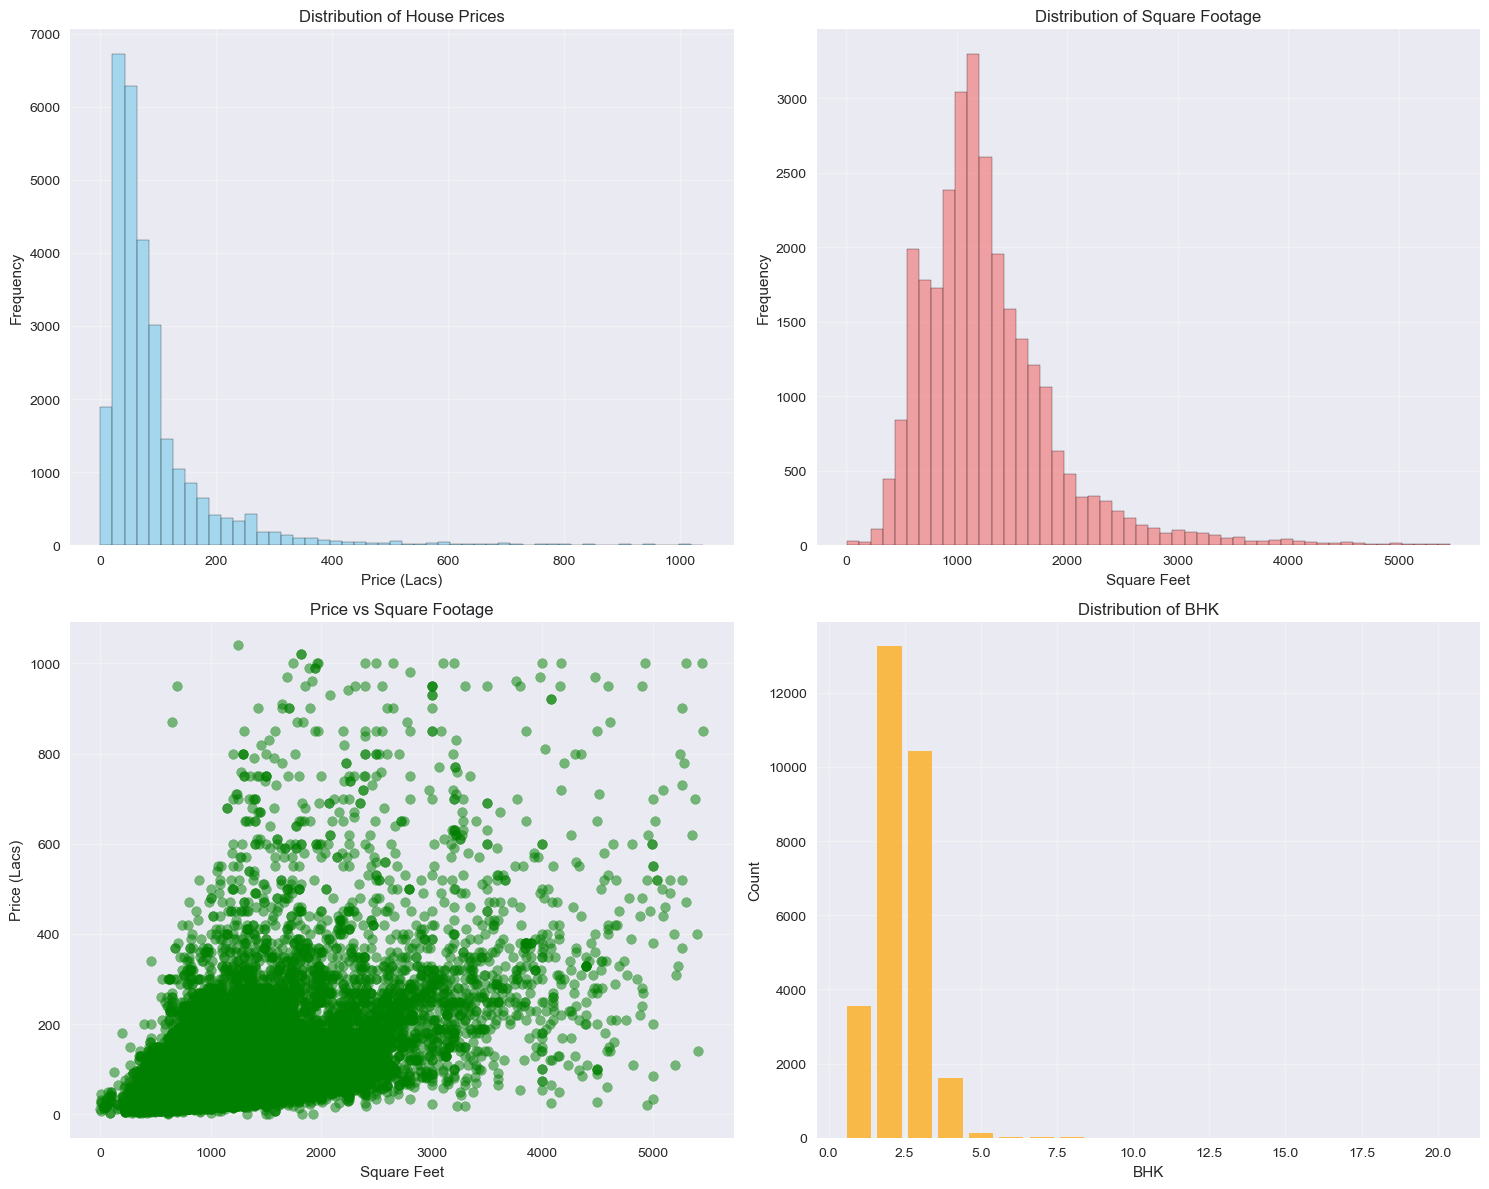

In [8]:
# Data visualization
# =================================================================
# 4. Data Visualization
# =================================================================

print("="*50)
print("DATA VISUALIZATION")
print("="*50)

# Set up the visualization style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of target price
axes[0,0].hist(data_train_filtered['TARGET_PRICE_IN_LACS'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Price (Lacs)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of House Prices')
axes[0,0].grid(True, alpha=0.3)

# Distribution of square footage
axes[0,1].hist(data_train_filtered['SQUARE_FT'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_xlabel('Square Feet')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Square Footage')
axes[0,1].grid(True, alpha=0.3)

# Price vs Square Feet
axes[1,0].scatter(data_train_filtered['SQUARE_FT'], data_train_filtered['TARGET_PRICE_IN_LACS'], 
                  alpha=0.5, color='green')
axes[1,0].set_xlabel('Square Feet')
axes[1,0].set_ylabel('Price (Lacs)')
axes[1,0].set_title('Price vs Square Footage')
axes[1,0].grid(True, alpha=0.3)

# BHK distribution
bhk_counts = data_train_filtered['BHK_NO'].value_counts().sort_index()
axes[1,1].bar(bhk_counts.index, bhk_counts.values, color='orange', alpha=0.7)
axes[1,1].set_xlabel('BHK')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Distribution of BHK')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

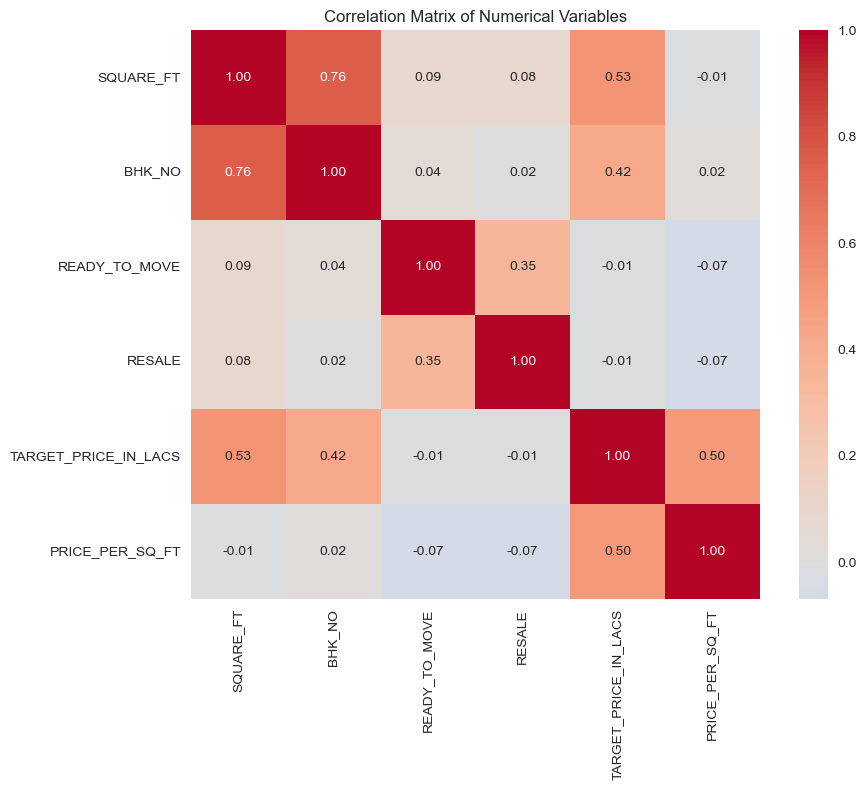

In [9]:
# Correlation heatmap
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = ['SQUARE_FT', 'BHK_NO', 'READY_TO_MOVE', 'RESALE', 'TARGET_PRICE_IN_LACS', 'PRICE_PER_SQ_FT']
correlation_matrix = data_train_filtered[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

In [10]:
# Prepare data for modeling
# =================================================================
# 5. Model Training and Evaluation
# =================================================================

print("="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# -- A. Variable Definition (Multiple Regression) --
# Include multiple features for better predictive capability
features = ['SQUARE_FT', 'BHK_NO', 'READY_TO_MOVE', 'RESALE']  # Added RESALE feature
target = 'TARGET_PRICE_IN_LACS'

X = data_train_filtered[features]
y = data_train_filtered[target]

# Split the dataset (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

MODEL TRAINING AND EVALUATION
Training set size: (20318, 4)
Test set size: (8709, 4)


In [11]:
# Data scaling and model training
# -- B. Data Standardization (Scaling) --
# Scale 'SQUARE_FT' so its large values don't dominate
scaler = StandardScaler()

# ONLY fit and transform on training data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['SQUARE_FT'] = scaler.fit_transform(X_train[['SQUARE_FT']])
X_test_scaled['SQUARE_FT'] = scaler.transform(X_test[['SQUARE_FT']])

print("\nFeature scaling completed")

# -- C. Model Training --
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Display model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"  Intercept: {model.intercept_:.4f}")

# Predictions
y_pred = model.predict(X_test_scaled)


Feature scaling completed

Model Coefficients:
  SQUARE_FT: 52.0915
  BHK_NO: 4.8996
  READY_TO_MOVE: -13.0714
  RESALE: -12.7612
  Intercept: 103.3040


In [12]:
# Model evaluation
# =================================================================
# 6. Model Evaluation
# =================================================================

print("="*50)
print("MODEL EVALUATION")
print("="*50)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Optimized Multiple Regression Model Results ---")
print(f"R-Squared (R2): {r2:.4f} (Closer to 1 is better)")
print(f"Mean Absolute Error (MAE): {mae:.2f} Lakh Rupees (Average error)")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Lakh Rupees (Error penalizing large deviations)")
print("-" * 80)

MODEL EVALUATION

--- Optimized Multiple Regression Model Results ---
R-Squared (R2): 0.2834 (Closer to 1 is better)
Mean Absolute Error (MAE): 49.33 Lakh Rupees (Average error)
Root Mean Squared Error (RMSE): 84.71 Lakh Rupees (Error penalizing large deviations)
--------------------------------------------------------------------------------


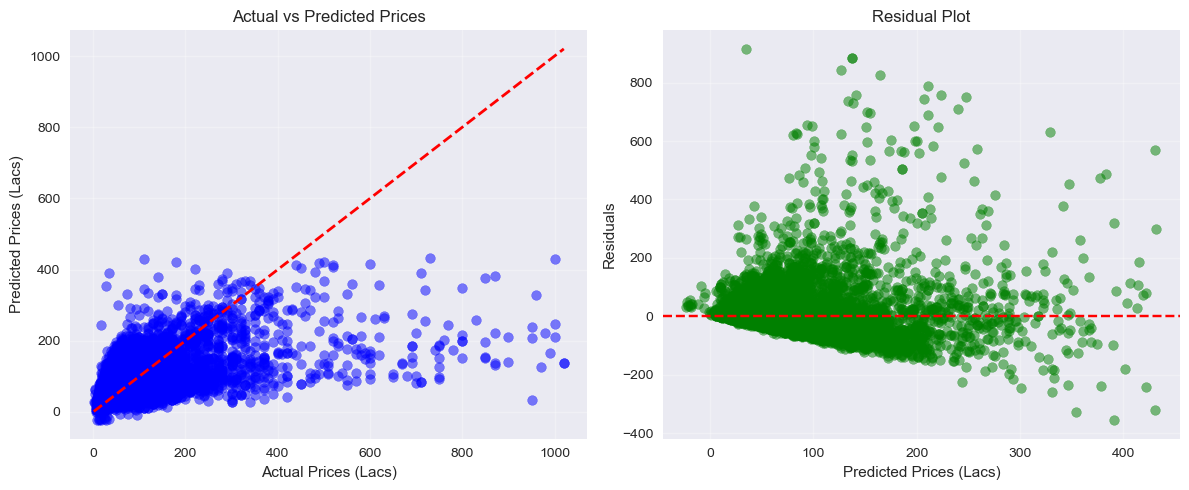

In [13]:
# Visualization of predictions
# Visualization of predictions vs actual values
plt.figure(figsize=(12, 5))

# Plot 1: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices (Lacs)')
plt.ylabel('Predicted Prices (Lacs)')
plt.title('Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices (Lacs)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Adding predicted prices to dataset
# =================================================================
# 7. Add Predicted Prices to Dataset
# =================================================================

print("="*50)
print("ADDING PREDICTED PRICES TO DATASET")
print("="*50)

# Prepare the entire filtered dataset for prediction
X_full = data_train_filtered[features].copy()
X_full_scaled = X_full.copy()
X_full_scaled['SQUARE_FT'] = scaler.transform(X_full[['SQUARE_FT']])

# Make predictions on the entire filtered dataset
full_predictions = model.predict(X_full_scaled)

# Add predicted prices as a new column
data_train_filtered['PREDICTED_PRICE_LACS'] = full_predictions

# Calculate prediction error
data_train_filtered['PREDICTION_ERROR'] = (
    data_train_filtered['TARGET_PRICE_IN_LACS'] - data_train_filtered['PREDICTED_PRICE_LACS']
)

print("Predicted prices added to dataset!")
print(f"New columns added: PREDICTED_PRICE_LACS, PREDICTION_ERROR")

# Display some examples with predictions
print("\nSample of actual vs predicted prices:")
sample_data = data_train_filtered[['SQUARE_FT', 'BHK_NO', 'READY_TO_MOVE', 
                                   'TARGET_PRICE_IN_LACS', 'PREDICTED_PRICE_LACS', 
                                   'PREDICTION_ERROR']].head(10)
display(sample_data.round(2))

# Summary of prediction accuracy
avg_absolute_error = np.mean(np.abs(data_train_filtered['PREDICTION_ERROR']))
print(f"\nAverage absolute prediction error on full dataset: {avg_absolute_error:.2f} Lacs")

ADDING PREDICTED PRICES TO DATASET
Predicted prices added to dataset!
New columns added: PREDICTED_PRICE_LACS, PREDICTION_ERROR

Sample of actual vs predicted prices:


,SQUARE_FT,BHK_NO,READY_TO_MOVE,TARGET_PRICE_IN_LACS,PREDICTED_PRICE_LACS,PREDICTION_ERROR
0,1300.24,2,1,55.0,88.91,-33.91
1,1275.00,2,1,51.0,86.82,-35.82
2,933.16,2,1,43.0,58.49,-15.49
3,929.92,2,1,62.5,58.22,4.28
4,999.01,2,0,60.5,77.02,-16.52
5,1250.00,3,1,42.0,89.65,-47.65
6,1495.05,3,1,66.5,109.96,-43.46
7,1181.01,3,1,52.0,83.93,-31.93
8,1040.00,2,1,41.6,67.34,-25.74
9,879.12,2,1,36.0,54.01,-18.01



Average absolute prediction error on full dataset: 50.55 Lacs


FEATURE IMPORTANCE ANALYSIS

Feature Importance (based on coefficient magnitude):


,Feature,Coefficient,Absolute_Coefficient
0,SQUARE_FT,52.091506,52.091506
2,READY_TO_MOVE,-13.071362,13.071362
3,RESALE,-12.761239,12.761239
1,BHK_NO,4.899557,4.899557


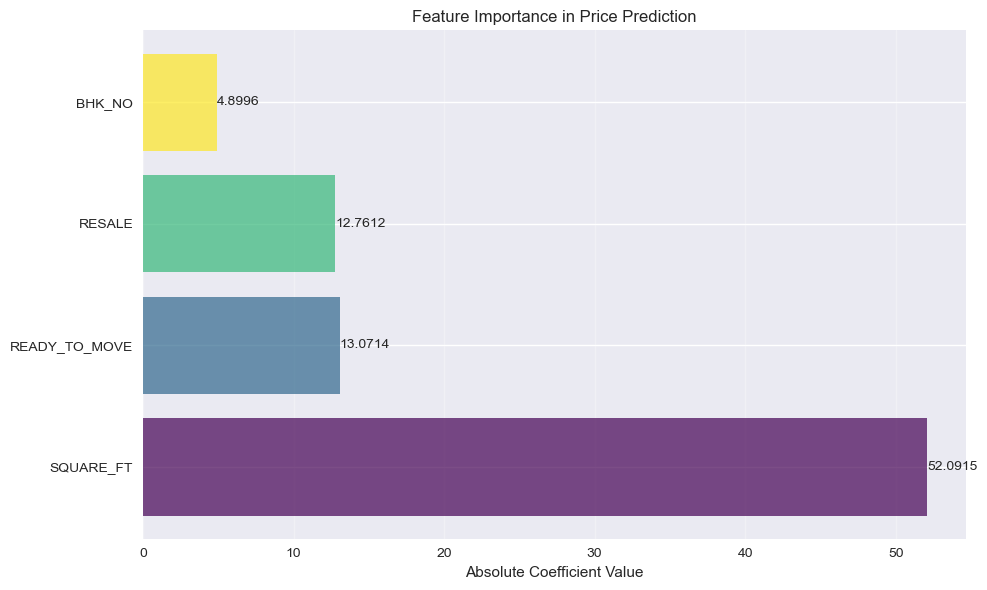

In [15]:
# Feature importance analysis
# =================================================================
# 8. Feature Importance Analysis
# =================================================================

print("="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Create a DataFrame with feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_,
    'Absolute_Coefficient': np.abs(model.coef_)
}).sort_values('Absolute_Coefficient', ascending=False)

print("\nFeature Importance (based on coefficient magnitude):")
display(feature_importance)

# Visualization of feature importance
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Absolute_Coefficient'], 
                color=colors, alpha=0.7)
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance in Price Prediction')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [16]:
# Final summary and export
# =================================================================
# 9. Final Summary
# =================================================================

print("="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"Original dataset size: {data_train.shape}")
print(f"Final cleaned dataset size: {data_train_filtered.shape}")
print(f"Model performance (R²): {r2:.4f}")
print(f"Key features used: {', '.join(features)}")
print(f"Predicted prices added as 'PREDICTED_PRICE_LACS' column")

# Display final dataset info
print("\nFinal dataset columns:")
print(data_train_filtered.columns.tolist())

# Save the enhanced dataset with predictions
try:
    data_train_filtered.to_csv('house_prices_with_predictions.csv', index=False)
    print("\nEnhanced dataset saved as 'house_prices_with_predictions.csv'")
except Exception as e:
    print(f"\nCould not save file: {e}")
    print("Enhanced dataset ready in memory (data_train_filtered)")

print("\n" + "="*50)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*50)

FINAL SUMMARY
Original dataset size: (29451, 12)
Final cleaned dataset size: (29027, 15)
Model performance (R²): 0.2834
Key features used: SQUARE_FT, BHK_NO, READY_TO_MOVE, RESALE
Predicted prices added as 'PREDICTED_PRICE_LACS' column

Final dataset columns:
['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE', 'TARGET_PRICE_IN_LACS', 'PRICE_PER_SQ_FT', 'PREDICTED_PRICE_LACS', 'PREDICTION_ERROR']

Enhanced dataset saved as 'house_prices_with_predictions.csv'

ANALYSIS COMPLETED SUCCESSFULLY!


In [17]:
# Optional: Display final dataset with predictions
print("Final dataset with predictions (first 10 rows):")
display(data_train_filtered.head(10))

print(f"\nDataset shape with new columns: {data_train_filtered.shape}")
print(f"New columns added: PRICE_PER_SQ_FT, PREDICTED_PRICE_LACS, PREDICTION_ERROR")

Final dataset with predictions (first 10 rows):


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET_PRICE_IN_LACS,PRICE_PER_SQ_FT,PREDICTED_PRICE_LACS,PREDICTION_ERROR
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,0.04230,88.911754,-33.911754
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,0.04000,86.819994,-35.819994
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,0.04608,58.486019,-15.486019
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,0.06721,58.217585,4.282415
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,0.06056,77.015424,-16.515424
5,Owner,0,0,3,BHK,1250.000000,1,1,"South Chittoor,Kochi",10.033280,76.282571,42.0,0.03360,89.647387,-47.647387
6,Dealer,0,0,3,BHK,1495.053957,1,1,"Sodala,Jaipur",26.916347,75.795600,66.5,0.04448,109.959074,-43.459074
7,Owner,0,1,3,BHK,1181.012946,1,1,"Kharar,Mohali",30.740000,76.650000,52.0,0.04403,83.929285,-31.929285
8,Dealer,0,1,2,BHK,1040.000000,1,1,"Bileshivale,Bangalore",13.054202,77.674002,41.6,0.04000,67.341646,-25.741646
9,Owner,0,1,2,BHK,879.120879,1,1,"Chromepet,Chennai",12.951610,80.140970,36.0,0.04095,54.006924,-18.006924



Dataset shape with new columns: (29027, 15)
New columns added: PRICE_PER_SQ_FT, PREDICTED_PRICE_LACS, PREDICTION_ERROR
